In [145]:
import numpy as np
import os
import cv2
import pandas as pd
import sounddevice as sd
import matplotlib.pyplot as plt

from scipy.fftpack import fft
from scipy.io import wavfile
from deepface import DeepFace

In [146]:
DIR_FILES_IMAGES = os.getcwd() + "\\images\\"
DIR_FILES_WAV = os.getcwd() + "\\music_wav\\"

In [147]:
def generateTone(frequency, duration, sr=44100, A=0.5):
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    wave = A * np.sin(2 * np.pi * frequency * t)
    return t, wave

In [148]:
def applyFourierFilter(image_path, filter_type='low', radius=50):    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    rows, cols = image.shape
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted) + 1)
    mask = np.zeros((rows, cols), np.uint8)
    center_x, center_y = cols // 2, rows // 2
    
    if filter_type == 'low': 
        cv2.circle(mask, (center_x, center_y), radius, 1, -1)
    elif filter_type == 'high':
        mask[:] = 1
        cv2.circle(mask, (center_x, center_y), radius, 0, -1)
    
    filtered_f_transform = f_transform_shifted * mask
    f_ishift = np.fft.ifftshift(filtered_f_transform)
    image_filtered = np.fft.ifft2(f_ishift)
    image_filtered = np.abs(image_filtered)
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title("Imagen Original")
    ax[0].axis("off")
    
    ax[1].imshow(magnitude_spectrum, cmap='gray')
    ax[1].set_title("Transformada de Fourier")
    ax[1].axis("off")
    
    ax[2].imshow(mask, cmap='gray')
    ax[2].set_title(f"Máscara {filter_type.capitalize()} (Radio={radius})")
    ax[2].axis("off")
    
    ax[3].imshow(image_filtered, cmap='gray')
    ax[3].set_title("Imagen Filtrada")
    ax[3].axis("off")
    
    plt.show()
    return image_filtered

In [149]:
def plots(file):
    img = cv2.imread(file)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    grises = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_color_b = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist_color_g = cv2.calcHist([img], [1], None, [256], [0, 256])
    hist_color_r = cv2.calcHist([img], [2], None, [256], [0, 256])

    hist_color_h = cv2.calcHist([hsv], [0], None, [256], [0, 256])
    hist_color_s = cv2.calcHist([hsv], [1], None, [256], [0, 256])
    hist_color_v = cv2.calcHist([hsv], [2], None, [256], [0, 256])

    hist_gris = cv2.calcHist([grises], [0], None, [256], [0, 256])
    fig, ax = plt.subplots(3, 3, figsize=(16, 8))
    fig.tight_layout()

    ax[0][0].plot(hist_color_r, color='r')
    ax[0][0].set_title("Histograma R")
    ax[0][1].plot(hist_color_g, color='g')
    ax[0][1].set_title("Histograma G")
    ax[0][2].plot(hist_color_b, color='b')
    ax[0][2].set_title("Histograma B")

    ax[1][0].plot(hist_color_h, color='orange')
    ax[1][0].set_title("Histograma H")
    ax[1][1].plot(hist_color_s, color='g')
    ax[1][1].set_title("Histograma S")
    ax[1][2].plot(hist_color_v, color='b')
    ax[1][2].set_title("Histograma V")

    ax[2][0].plot(hist_gris, color='black')
    ax[2][0].set_title("Histograma (Escala de Grises)")
    ax[2][1].imshow(grises, cmap='gray')
    ax[2][1].set_title("Grayscale")
    ax[2][2].imshow(rgb)
    ax[2][2].set_title("Original RGB")

    plt.show()
    return hist_color_r, hist_color_g, hist_color_b, hist_color_h, hist_color_s, hist_color_v, hist_gris, hsv

In [150]:
def generateWavfile(frequencies, filename, duration = 0.1):
    """
        generate WAV file

        Parameters:
        frequencies (ndarray): array of frequencies.
        filename (string): name to wav file.
    """
    song = []
    sr = 44100
    for i in range(frequencies.size):
        frequency = frequencies[i]
        x1, note = generateTone(frequency, duration = duration, sr = sr)
        song = np.concatenate([song, note])

    wavfile.write(filename, rate = sr, data = song.astype(np.float32))

In [151]:
def buildPianoNotes(base_frequency=440):   
    octave = ['C', 'c', 'D', 'd', 'E', 'F', 'f', 'G', 'g', 'A', 'a', 'B']
    keys = np.array([x+str(y) for y in range(0,9) for x in octave])
    start = np.where(keys == 'A0')[0][0]
    end = np.where(keys == 'C8')[0][0]
    keys = keys[start:end+1]
    note_freqs = dict(zip(keys, [ base_frequency * pow(2,((i+1-49)/12)) for i in range(len(keys))]))
    return note_freqs

In [152]:
def hue2freq(h, thresholds, scaleFreqs):
    note = scaleFreqs[0]
    thresholds_comp = [i <= h for i in thresholds]
    if(thresholds_comp.count(False) > 0):
        idx = thresholds_comp.index(False)
        if(idx > 0):
            note = scaleFreqs[idx-1]
    else:
        note = scaleFreqs[len(scaleFreqs)-1]
    return note

In [164]:
def makeScale(whichOctave, whichKey, whichScale):
    note_freqs = buildPianoNotes()
    scale_intervals = ['A','a','B','C','c','D','d','E','F','f','G','g']
    index = scale_intervals.index(whichKey)
    new_scale = scale_intervals[index:12] + scale_intervals[:index]
    time = 0.1
    if whichScale == 'sad': # 'AEOLIAN'
        scale = [0, 2, 3, 5, 7, 8, 10]
        time = 0.3
    elif whichScale == 'angry': #'BLUES'
        scale = [0, 2, 3, 4, 5, 7, 9, 10, 11]
        time = 0.2
    elif whichScale == 'neutral': #'CHROMATIC'
        scale = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        time = 0.15
    elif whichScale == 'surprise': #'DORIAN'
        scale = [0, 2, 3, 5, 7, 9, 10]
        time = 0.18
    elif whichScale == 'happy': #'MAJOR':
        scale = [0, 2, 4, 5, 7, 9, 11]
        time = 0.12
    elif whichScale == 'fear': #'MIXOLYDIAN'     
        scale = [0, 2, 4, 5, 7, 9, 10]
        time = 0.25
    elif whichScale == 'disgust': #'PENTATONIC'   
        scale = [0, 2, 4, 7, 9]
        time = 0.27
    else:
        scale = [0, 2, 4, 5, 7, 9, 11]
        time = 0.1
    
    nNotes = len(scale)
    freqs = []
    for i in range(nNotes):
        note = new_scale[scale[i]] + str(whichOctave)
        freqToAdd = note_freqs[note]
        freqs.append(freqToAdd)
    return freqs, time

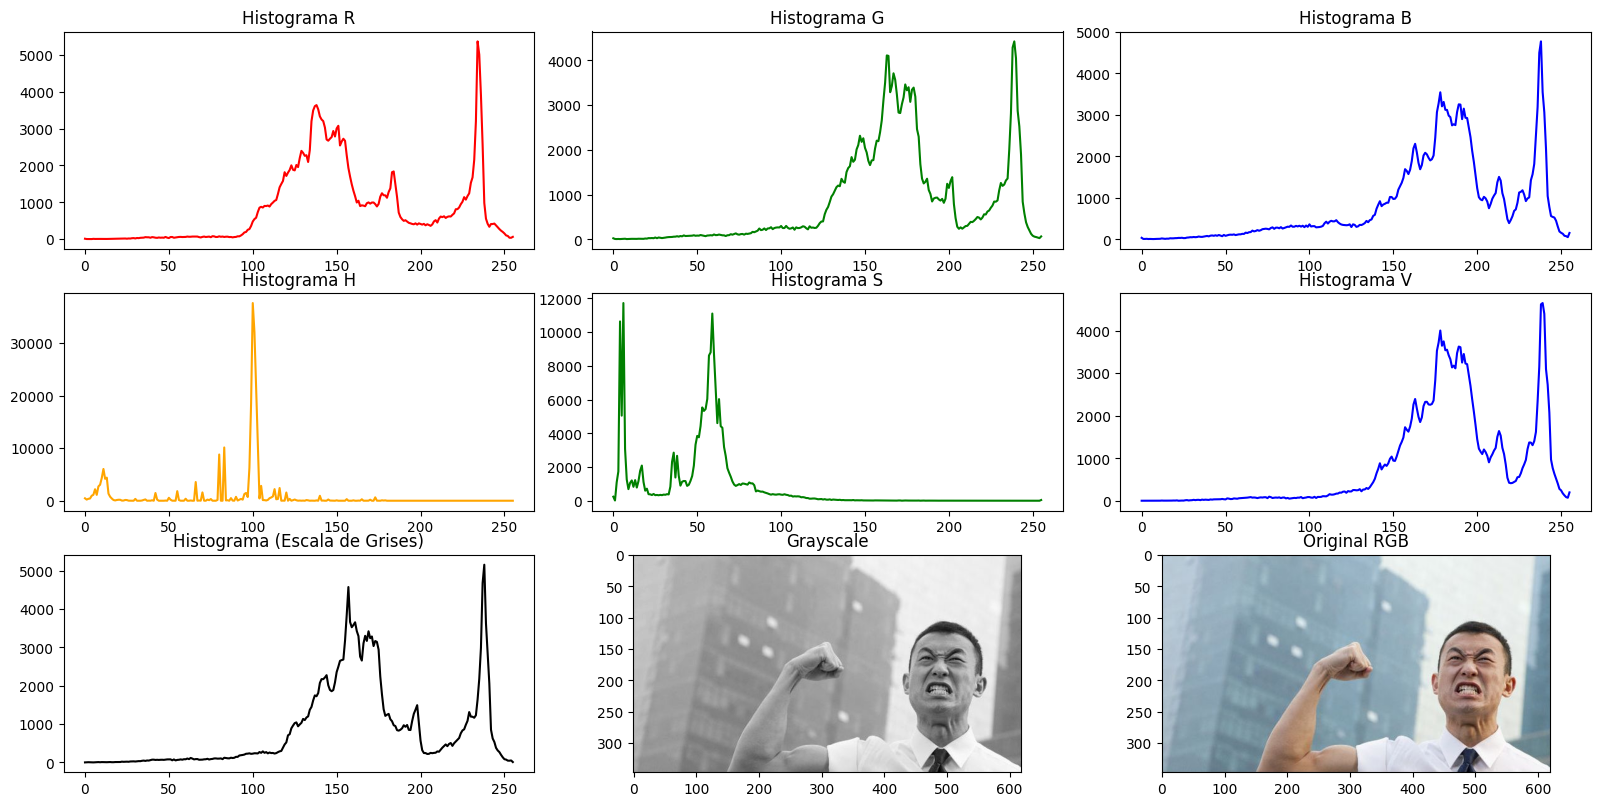

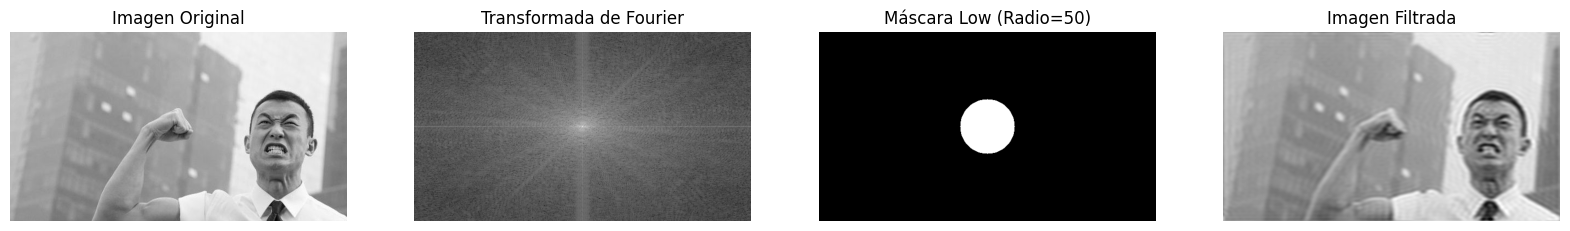

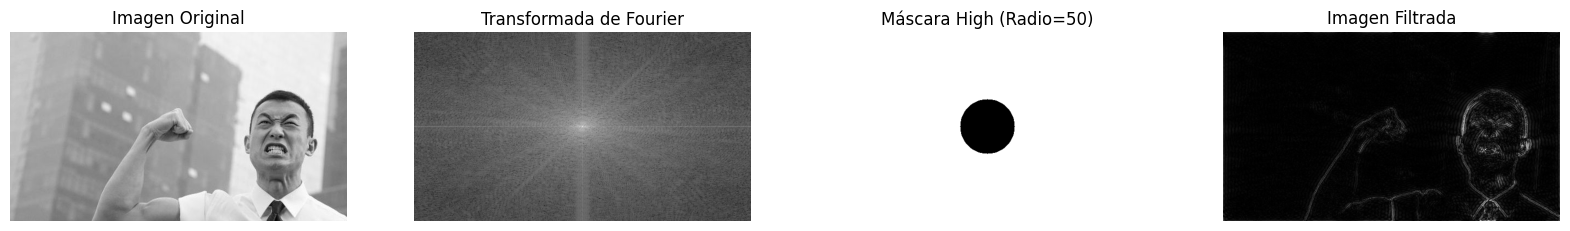

In [154]:
image = "image15.jpg"
file = DIR_FILES_IMAGES + image
fileWav = DIR_FILES_WAV + image.replace(".jpg", ".wav")
HR, HG, HB, HH, HS, HV, HGR, HSV_IMG = plots(file)
image_filtered_low = applyFourierFilter(file, filter_type='low', radius=50)
image_filtered_high = applyFourierFilter(file, filter_type='high', radius=50)

variables = {
    "HR": HR, 
    "HG": HG, 
    "HB": HB, 
    "HH": HH, 
    "HS": HS, 
    "HV": HV,
    "HGR": HGR
}
for name, h in variables.items():
    generateWavfile(h.flatten(), fileWav.replace(".wav", f"-{name}.wav"))

214793


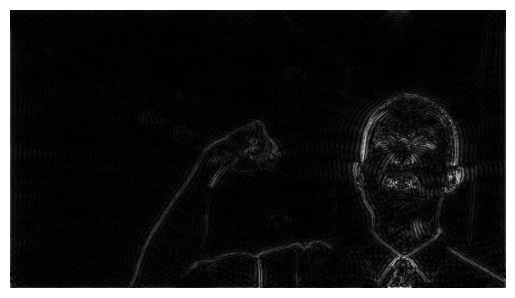

In [155]:
closed = image_filtered_high
image_cp = closed.copy()
image = closed.flatten()
median = np.median(image)
mean = np.mean(image)
d1, d2 = closed.shape
frequencies_h, frequencies_s, frequencies_v = [], [], []
for x in range(d1):
    for y in range(d2):
            # if image_cp[x][y] < median:
            #     image_cp[x][y] = 255
            # else:
        frequencies_h.append(HSV_IMG[x][y][0]) # get H value
        frequencies_s.append(HSV_IMG[x][y][1]) # get S value
        frequencies_v.append(HSV_IMG[x][y][2]) # get V value

plt.imshow(image_cp, cmap='gray')
plt.axis("off")

print(len(frequencies_h))

In [156]:
generateWavfile(np.array(frequencies_h[:250]), fileWav.replace(".wav", "-TF-PasAlto.wav"))

In [157]:
analysis = DeepFace.analyze(img_path=file, enforce_detection=False)
emotion = analysis[0]['dominant_emotion']
emotion

Action: race: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]  


'angry'

In [158]:
# Histograma
freq = np.array(frequencies_h)
frecuencias, extremos = np.histogram(freq, bins=80)
extremos = np.array(extremos)
extremos = extremos[1:]

max = np.max(frequencies_h)
min = np.min(frequencies_h)

scale, time = makeScale(3, 'A', emotion)
thr = [i for i in range(min, max, int(max/len(scale)))]
thr = thr[1:]

octaves = np.array([0.5,1,2])
freq_final = [ hue2freq(value, thr, scale) * np.random.choice(octaves) for value in extremos ]

generateWavfile(np.array(freq_final), fileWav.replace(".wav", "-h-song.wav"), time)


In [159]:
# Histograma 3
freq = np.array(frequencies_h)
frecuencias, extremos = np.histogram(freq, bins=80)
extremos = np.array(extremos)
extremos = extremos[1:]

max = np.max(frequencies_h)
min = np.min(frequencies_h)
scale, time = makeScale(3, 'A', emotion)
thr = [i for i in range(min, max, int(max/len(scale)))]
thr = thr[1:]

octaves = np.array([0.5,1,2])
freq_final_1 = [ hue2freq(value, thr, scale)  for value in extremos ]


freq = np.array(frequencies_s)
frecuencias, extremos = np.histogram(freq, bins=80)
extremos = np.array(extremos)
extremos = extremos[1:]

max = np.max(frequencies_s)
min = np.min(frequencies_s)
scale, time = makeScale(2, 'B', emotion)
thr = [i for i in range(min, max, int(max/len(scale)))]
thr = thr[1:]

octaves = np.array([0.5,1,2])
freq_final_2 = [ hue2freq(value, thr, scale) * np.random.choice(octaves) for value in extremos ]


freq = np.array(frequencies_v)
frecuencias, extremos = np.histogram(freq, bins=80)
extremos = np.array(extremos)
extremos = extremos[1:]

max = np.max(frequencies_v)
min = np.min(frequencies_v)
scale, time = makeScale(4, 'd', emotion)
thr = [i for i in range(min, max, int(max/len(scale)))]
thr = thr[1:]

octaves = np.array([0.5,1,2])
freq_final_3 = [ hue2freq(value, thr, scale)  for value in extremos ]

freq_final = np.add(freq_final_1 , freq_final_2)
freq_final = np.add(freq_final , freq_final_3)
generateWavfile(np.array(freq_final), fileWav.replace(".wav", "-h3-song.wav"), time)

In [165]:
# All values
size = 120
area = frequencies_h
li = np.random.randint(1, len(area), size=size).tolist()
list_freq_h = [frequencies_h[i] for i in li]
list_freq_s = [frequencies_s[i] for i in li]
list_freq_v = [frequencies_v[i] for i in li]

freq = np.array(list_freq_h)
max = np.max(frequencies_h)
min = np.min(frequencies_h)
scale, time = makeScale(3, 'd', emotion)
thr = [i for i in range(min, max, int(max/len(scale)))]
thr = thr[1:]

low_threshold_s = np.percentile(list_freq_s, 33)
mid_threshold_s = np.percentile(list_freq_s, 66)
octaves_s = np.select(
    [list_freq_s <= low_threshold_s, list_freq_s <= mid_threshold_s, list_freq_s > mid_threshold_s],
    [0.5, 1, 2]
)

low_threshold_v = np.percentile(list_freq_v, 33)
mid_threshold_v = np.percentile(list_freq_v, 66)
octaves_v = np.select(
    [list_freq_v <= low_threshold_v, list_freq_v <= mid_threshold_v, list_freq_v > mid_threshold_v],
    [0.5, 1, 2]
)

freq_final = [ hue2freq(frequencies_h[item], thr, scale) * octaves_s[idx] * octaves_v[idx] for idx, item in enumerate(li) ]
generateWavfile(np.array(freq_final), fileWav.replace(".wav", "-randon-song.wav"), time)